Training for fold 1...
Fold 1 Accuracy: 85.11%
Training for fold 2...
Fold 2 Accuracy: 87.23%
Training for fold 3...
Fold 3 Accuracy: 93.62%
Training for fold 4...
Fold 4 Accuracy: 80.85%
Training for fold 5...
Fold 5 Accuracy: 82.98%
Training for fold 6...
Fold 6 Accuracy: 78.72%
Training for fold 7...
Fold 7 Accuracy: 91.49%
Training for fold 8...
Fold 8 Accuracy: 89.36%
Training for fold 9...
Fold 9 Accuracy: 78.72%
Training for fold 10...
Fold 10 Accuracy: 82.98%
Average Accuracy: 85.11%


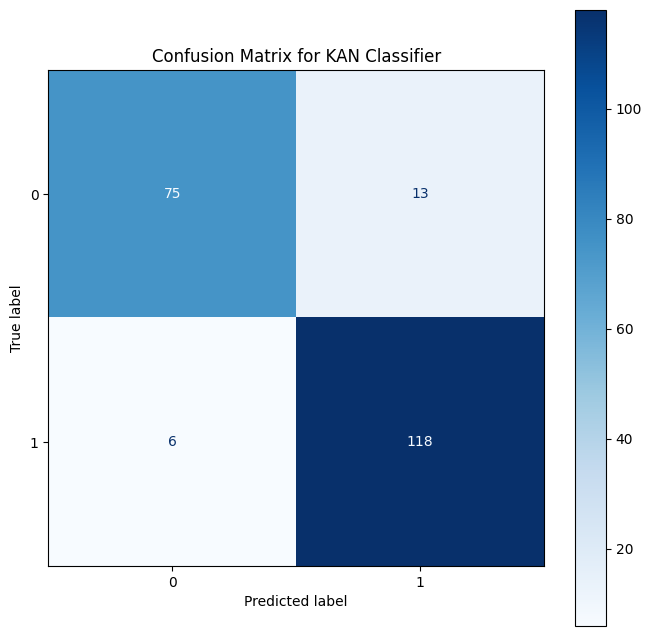

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import optuna

# Custom KAN layer
class KANLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_rate=0.2):
        super(KANLayer, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(self.fc(x))

# Custom KAN model
class KAN(nn.Module):
    def __init__(self, width):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(width) - 1):
            self.layers.append(KANLayer(width[i], width[i+1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                x = torch.relu(layer(x))
            else:
                x = torch.sigmoid(layer(x))
        return x

# Load the dataset
file_path = 'Final_dataset_Classific.xlsx' 
dataset = pd.read_excel(file_path)
cols_to_drop = dataset.filter(like='Medication_').columns
dataset = dataset.drop(columns=cols_to_drop)

# Prepare data for the classification task
dataset['Outcome_numerical_step1'] = dataset['Outcome_numerical'].replace(2, 0)
X = dataset.drop(columns=['Outcome_numerical', 'Outcome_numerical_step1'])
y = dataset['Outcome_numerical_step1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
accuracies = []

def train_kan(model, criterion, optimizer, scheduler, X_train, y_train, epochs=100):
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step()

for train, test in kfold.split(X_scaled, y):
    print(f'Training for fold {fold_no}...')

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_scaled[train], dtype=torch.float32)
    y_train_tensor = torch.tensor(y.iloc[train].values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_scaled[test], dtype=torch.float32)
    y_test_tensor = torch.tensor(y.iloc[test].values, dtype=torch.float32).view(-1, 1)

    # Initialize the KAN model
    width = [X_train_tensor.shape[1], 128, 64, 32, 1] 
    kan_model = KAN(width=width)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(kan_model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    # Train the KAN model
    train_kan(kan_model, criterion, optimizer, scheduler, X_train_tensor, y_train_tensor, epochs=50)

    # Make predictions on the test set
    kan_model.eval()
    with torch.no_grad():
        y_pred_step1_tensor = kan_model(X_test_tensor)
    y_pred_step1 = (y_pred_step1_tensor.numpy() > 0.5).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(y.iloc[test], y_pred_step1)
    accuracies.append(accuracy)

    print(f'Fold {fold_no} Accuracy: {accuracy * 100:.2f}%')
    fold_no += 1

print(f'Average Accuracy: {np.mean(accuracies) * 100:.2f}%')

# Final model evaluation on the whole test set
train_data, test_data = train_test_split(dataset, test_size=0.45, random_state=42)
X_test = test_data.drop(columns=['Outcome_numerical', 'Outcome_numerical_step1'])
X_test_scaled = scaler.transform(X_test)
y_test = test_data['Outcome_numerical'].replace(2, 0)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Make predictions on the test set
kan_model.eval()
with torch.no_grad():
    y_pred_step1_tensor = kan_model(X_test_tensor)
y_pred_step1 = (y_pred_step1_tensor.numpy() > 0.5).astype(int)

# Add predictions to test_data
test_data['Predicted_step1'] = y_pred_step1

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_step1)

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for KAN Classifier')
plt.show()


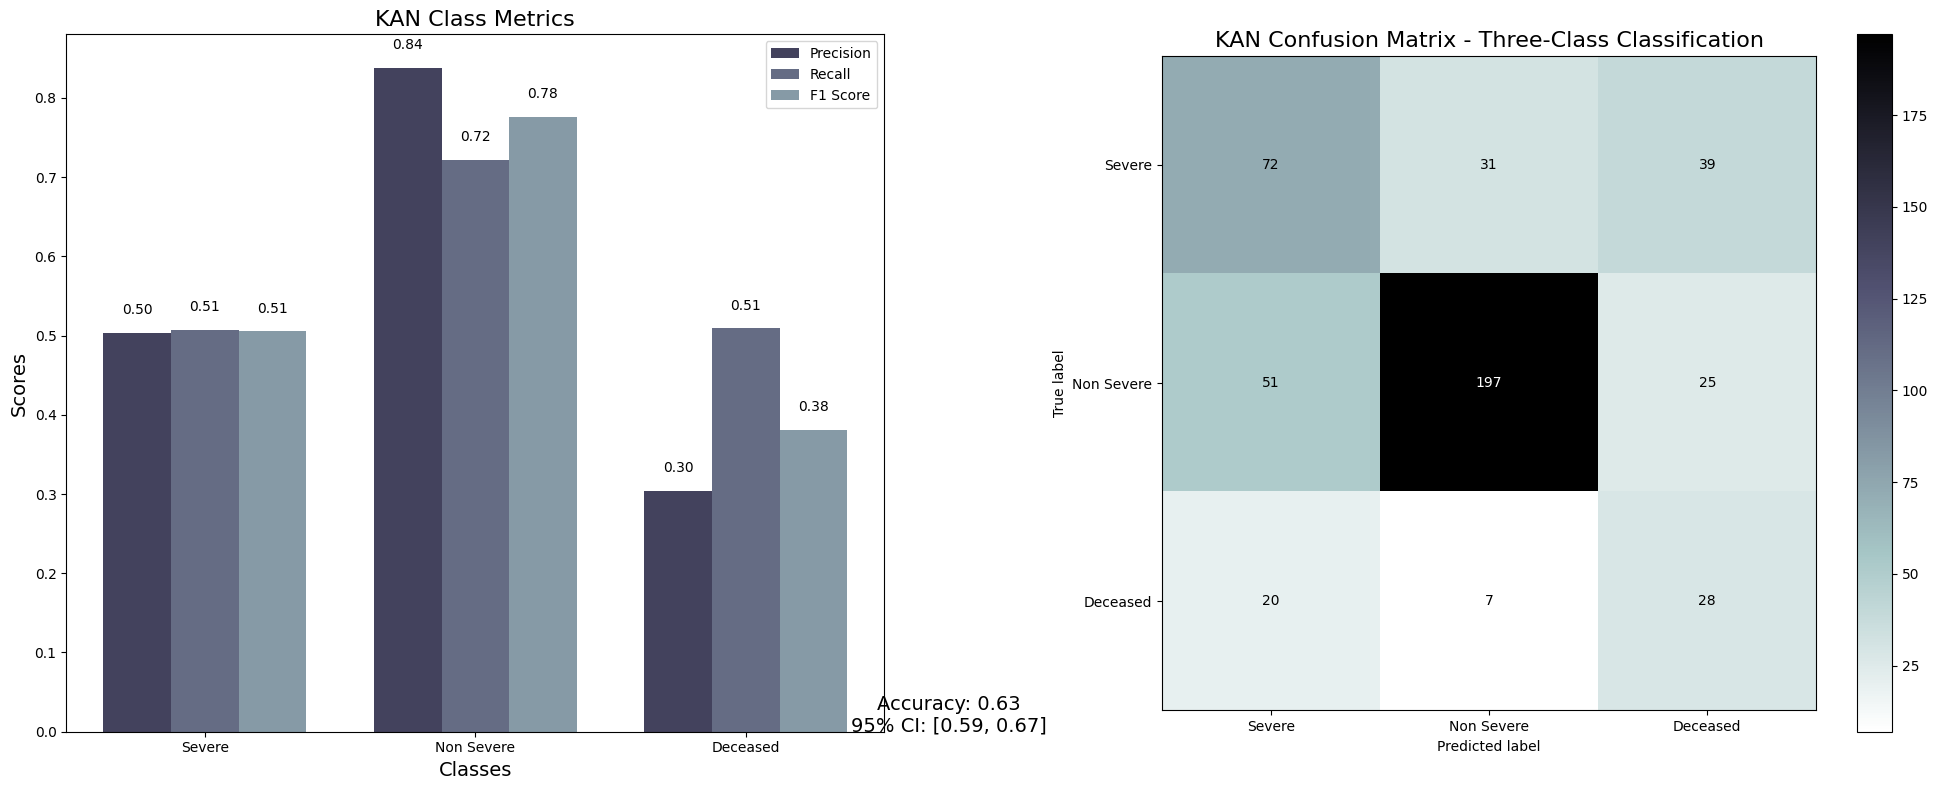

In [ ]:
# Custom KAN layer
class KANLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_rate=0.2):
        super(KANLayer, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(self.fc(x))

# Custom KAN model
class KAN(nn.Module):
    def __init__(self, width, dropout_rate=0.2):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(width) - 1):
            self.layers.append(KANLayer(width[i], width[i+1], dropout_rate=dropout_rate))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                x = torch.relu(layer(x))
            else:
                x = torch.softmax(layer(x), dim=1)
        return x

# Bootstrap function for calculating CI of accuracy
def bootstrap_accuracy(y_true, y_pred, n_iterations=1000):
    bootstrap_accuracies = []
    for i in range(n_iterations):
        indices = resample(np.arange(len(y_true)), replace=True)
        sampled_y_true = y_true[indices]
        sampled_y_pred = y_pred[indices]
        bootstrap_accuracies.append(accuracy_score(sampled_y_true, sampled_y_pred))
    return np.percentile(bootstrap_accuracies, [2.5, 97.5])

# K-fold cross-validation parameters
n_splits = 10
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Variables to store aggregated results
all_true_labels = []
all_pred_labels = []
total_scores = []

# Perform k-fold cross-validation
for train_idx, test_idx in kfold.split(X, y):
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X.iloc[train_idx])
    X_test_fold = scaler.transform(X.iloc[test_idx])
    smote = SMOTE(random_state=42)
    X_train_fold_sm, y_train_fold_sm = smote.fit_resample(X_train_fold, y.iloc[train_idx])

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold_sm, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold_sm.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_fold, dtype=torch.float32)
    y_test_tensor = torch.tensor(y.iloc[test_idx].values, dtype=torch.long)

    # Initialize the KAN model
    width = [X_train_tensor.shape[1], 128, 64, 3]  # Adjust the structure based on data
    kan_model = KAN(width=width, dropout_rate=0.2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(kan_model.parameters(), lr=0.001, weight_decay=1e-4)

    # Train the model
    epochs = 10
    for _ in range(epochs):
        kan_model.train()
        optimizer.zero_grad()
        output = kan_model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Make predictions
    kan_model.eval()
    with torch.no_grad():
        y_pred_tensor = torch.argmax(kan_model(X_test_tensor), dim=1)
    y_pred = y_pred_tensor.numpy()

    # Calculate metrics
    scores = accuracy_score(y.iloc[test_idx], y_pred)
    total_scores.append(scores)

    all_true_labels.extend(y.iloc[test_idx])
    all_pred_labels.extend(y_pred)

# Calculate overall metrics
overall_accuracy = np.mean(total_scores)
overall_precision = precision_score(all_true_labels, all_pred_labels, average=None)
overall_recall = recall_score(all_true_labels, all_pred_labels, average=None)
overall_f1 = f1_score(all_true_labels, all_pred_labels, average=None)
overall_confusion_matrix = confusion_matrix(all_true_labels, all_pred_labels)

# Calculate 95% Confidence Interval for the overall accuracy
confidence_interval = bootstrap_accuracy(np.array(all_true_labels), np.array(all_pred_labels))

# Visualization
class_labels = ['Severe', 'Non Severe', 'Deceased']
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))

# Plotting metrics
bar_width = 0.25
index = np.arange(len(class_labels))
axes[0].bar(index, overall_precision, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, overall_recall, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, overall_f1, bar_width, color=bone_palette[2], label='F1 Score')
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('KAN Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Adding text annotations for clarity
for i in range(len(class_labels)):
    axes[0].text(i, overall_precision[i] + 0.02, f'{overall_precision[i]:.2f}', ha='center', va='bottom')
    axes[0].text(i + bar_width, overall_recall[i] + 0.02, f'{overall_recall[i]:.2f}', ha='center', va='bottom')
    axes[0].text(i + 2 * bar_width, overall_f1[i] + 0.02, f'{overall_f1[i]:.2f}', ha='center', va='bottom')

# Adding CI and overall accuracy to the plot
axes[0].text(len(class_labels), 0, f'Accuracy: {overall_accuracy:.2f}\n95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]', fontsize=14, ha='center')

# Confusion Matrix Display
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=overall_confusion_matrix, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('KAN Confusion Matrix - Three-Class Classification', fontsize=16)

plt.tight_layout()
plt.show()


In [20]:
!pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
# Custom KAN layer
class KANLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_rate=0.2):
        super(KANLayer, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(self.fc(x))

# Custom KAN model
class KAN(nn.Module):
    def __init__(self, width, dropout_rate=0.2):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(width) - 1):
            self.layers.append(KANLayer(width[i], width[i+1], dropout_rate=dropout_rate))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                x = torch.relu(layer(x))
            else:
                x = torch.softmax(layer(x), dim=1)
        return x

# Function to perform cross-validation and return the average accuracy
def objective(trial):
    # Hyperparameters for optimization
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    layer_widths = [trial.suggest_int(f"layer_{i}", 32, 256) for i in range(3)]
    widths = [107] + layer_widths + [3]

    # K-fold cross-validation parameters
    n_splits = 5
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    total_scores = []

    # Perform k-fold cross-validation
    for train_idx, test_idx in kfold.split(X, y):
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X.iloc[train_idx])
        X_test_fold = scaler.transform(X.iloc[test_idx])
        smote = SMOTE(random_state=42)
        X_train_fold_sm, y_train_fold_sm = smote.fit_resample(X_train_fold, y.iloc[train_idx])

        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_fold_sm, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_fold_sm.values, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test_fold, dtype=torch.float32)
        y_test_tensor = torch.tensor(y.iloc[test_idx].values, dtype=torch.long)

        # Initialize the KAN model
        kan_model = KAN(width=widths, dropout_rate=dropout_rate)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(kan_model.parameters(), lr=lr, weight_decay=1e-4)

        # Train the model
        epochs = 10
        for _ in range(epochs):
            kan_model.train()
            optimizer.zero_grad()
            output = kan_model(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()

        # Make predictions
        kan_model.eval()
        with torch.no_grad():
            y_pred_tensor = torch.argmax(kan_model(X_test_tensor), dim=1)
        y_pred = y_pred_tensor.numpy()

        # Calculate metrics
        scores = accuracy_score(y.iloc[test_idx], y_pred)
        total_scores.append(scores)

    return np.mean(total_scores)

# Running hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

# Print best hyperparameters
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")


[I 2024-05-04 22:18:03,256] A new study created in memory with name: no-name-e7429671-f610-4e39-b84b-c2e9026d448c
[I 2024-05-04 22:18:04,567] Trial 0 finished with value: 0.7340425531914893 and parameters: {'dropout_rate': 0.30337321336855677, 'lr': 0.004177501708558378, 'layer_0': 179, 'layer_1': 190, 'layer_2': 95}. Best is trial 0 with value: 0.7340425531914893.
[I 2024-05-04 22:18:05,862] Trial 1 finished with value: 0.33617021276595743 and parameters: {'dropout_rate': 0.23080096917322368, 'lr': 0.0003770032870840277, 'layer_0': 67, 'layer_1': 206, 'layer_2': 150}. Best is trial 0 with value: 0.7340425531914893.
[I 2024-05-04 22:18:07,143] Trial 2 finished with value: 0.6957446808510638 and parameters: {'dropout_rate': 0.11594867762327406, 'lr': 0.00962595872075218, 'layer_0': 222, 'layer_1': 111, 'layer_2': 181}. Best is trial 0 with value: 0.7340425531914893.
[I 2024-05-04 22:18:08,470] Trial 3 finished with value: 0.6680851063829788 and parameters: {'dropout_rate': 0.41960100605

Best Hyperparameters: {'dropout_rate': 0.3652686760162851, 'lr': 0.0047836662404659135, 'layer_0': 162, 'layer_1': 143, 'layer_2': 59}


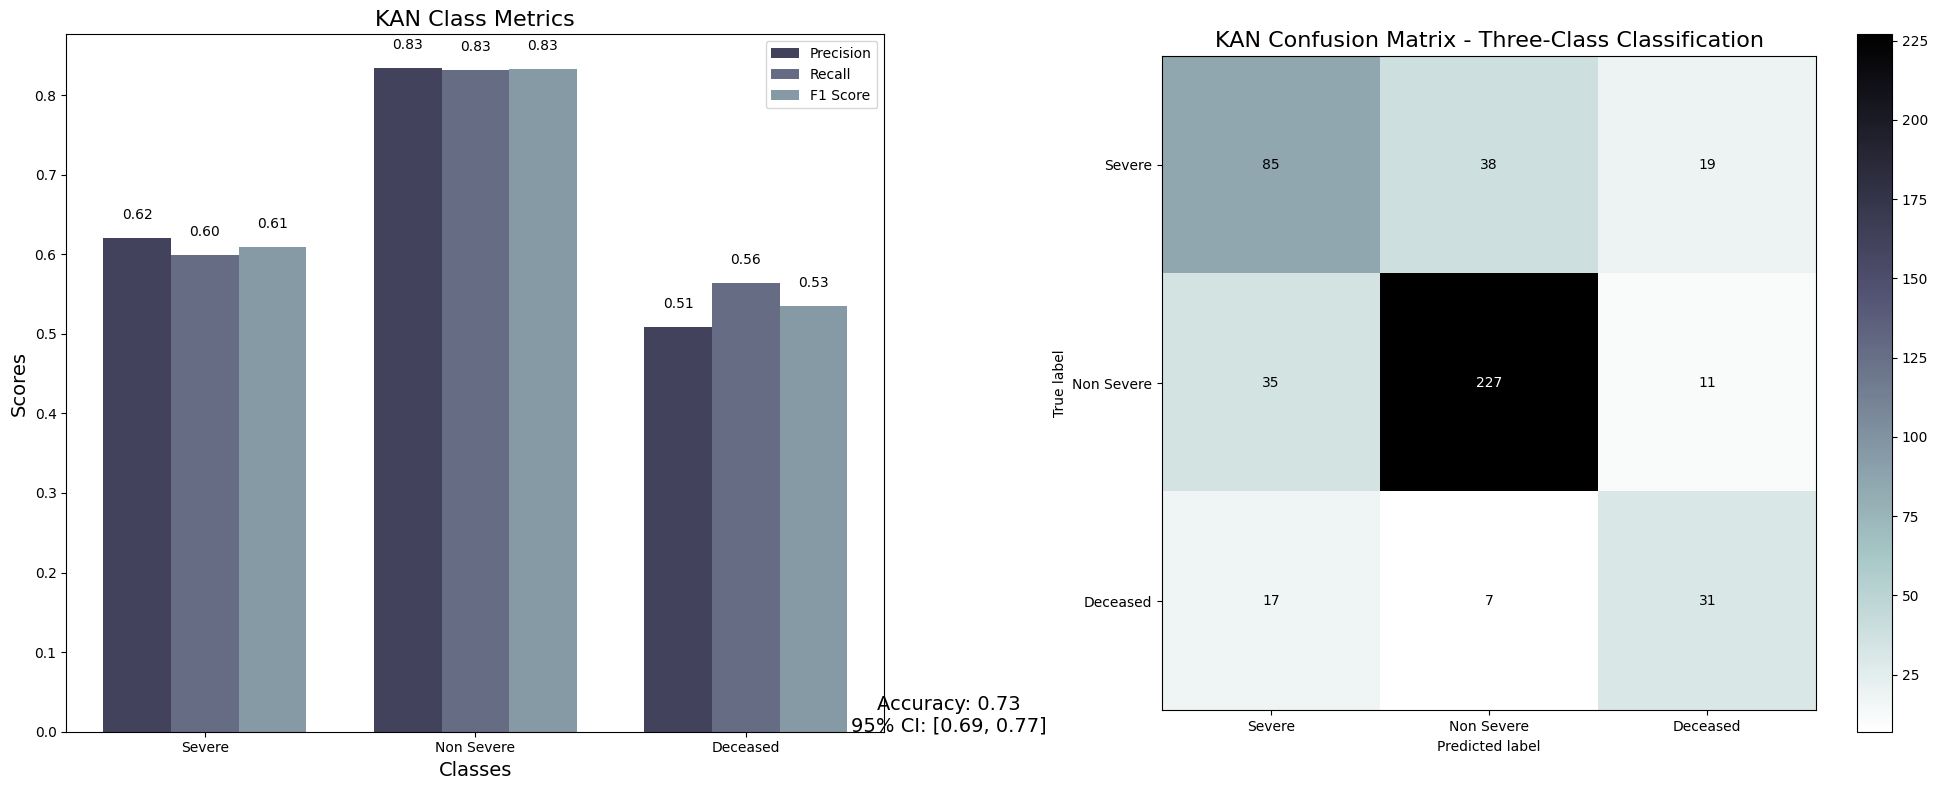

In [ ]:
# Custom KAN layer
class KANLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_rate=0.2):
        super(KANLayer, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(self.fc(x))

# Custom KAN model
class KAN(nn.Module):
    def __init__(self, width, dropout_rate=0.2):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(width) - 1):
            self.layers.append(KANLayer(width[i], width[i+1], dropout_rate=dropout_rate))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                x = torch.relu(layer(x))
            else:
                x = torch.softmax(layer(x), dim=1)
        return x

# Bootstrap function for calculating CI of accuracy
def bootstrap_accuracy(y_true, y_pred, n_iterations=1000):
    bootstrap_accuracies = []
    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)), replace=True)
        sampled_y_true = y_true[indices]
        sampled_y_pred = y_pred[indices]
        bootstrap_accuracies.append(accuracy_score(sampled_y_true, sampled_y_pred))
    return np.percentile(bootstrap_accuracies, [2.5, 97.5])

# Best hyperparameters found through optimization
best_params = {'dropout_rate': 0.365, 'lr': 0.00478, 'layer_0': 162, 'layer_1': 143, 'layer_2': 59}

# K-fold cross-validation parameters
n_splits = 10
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Variables to store aggregated results
all_true_labels = []
all_pred_labels = []
total_scores = []

# Perform k-fold cross-validation
for train_idx, test_idx in kfold.split(X, y):
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X.iloc[train_idx])
    X_test_fold = scaler.transform(X.iloc[test_idx])
    smote = SMOTE(random_state=42)
    X_train_fold_sm, y_train_fold_sm = smote.fit_resample(X_train_fold, y.iloc[train_idx])

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold_sm, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold_sm.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_fold, dtype=torch.float32)
    y_test_tensor = torch.tensor(y.iloc[test_idx].values, dtype=torch.long)

    # Initialize the KAN model with optimized hyperparameters
    width = [X_train_tensor.shape[1], best_params['layer_0'], best_params['layer_1'], best_params['layer_2'], 3]
    kan_model = KAN(width=width, dropout_rate=best_params['dropout_rate'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(kan_model.parameters(), lr=best_params['lr'], weight_decay=1e-4)

    # Train the model
    epochs = 20
    for _ in range(epochs):
        kan_model.train()
        optimizer.zero_grad()
        output = kan_model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Make predictions
    kan_model.eval()
    with torch.no_grad():
        y_pred_tensor = torch.argmax(kan_model(X_test_tensor), dim=1)
    y_pred = y_pred_tensor.numpy()

    # Calculate metrics
    scores = accuracy_score(y.iloc[test_idx], y_pred)
    total_scores.append(scores)

    all_true_labels.extend(y.iloc[test_idx])
    all_pred_labels.extend(y_pred)

# Calculate overall metrics
overall_accuracy = np.mean(total_scores)
overall_precision = precision_score(all_true_labels, all_pred_labels, average=None)
overall_recall = recall_score(all_true_labels, all_pred_labels, average=None)
overall_f1 = f1_score(all_true_labels, all_pred_labels, average=None)
overall_confusion_matrix = confusion_matrix(all_true_labels, all_pred_labels)
# Calculate 95% Confidence Interval for the overall accuracy
confidence_interval = bootstrap_accuracy(np.array(all_true_labels), np.array(all_pred_labels))

# Visualization
class_labels = ['Severe', 'Non Severe', 'Deceased']
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))

# Plotting metrics
bar_width = 0.25
index = np.arange(len(class_labels))

axes[0].bar(index, overall_precision, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, overall_recall, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, overall_f1, bar_width, color=bone_palette[2], label='F1 Score')

axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('KAN Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Adding text annotations for clarity
for i in range(len(class_labels)):
    axes[0].text(i, overall_precision[i] + 0.02, f'{overall_precision[i]:.2f}', ha='center', va='bottom')
    axes[0].text(i + bar_width, overall_recall[i] + 0.02, f'{overall_recall[i]:.2f}', ha='center', va='bottom')
    axes[0].text(i + 2 * bar_width, overall_f1[i] + 0.02, f'{overall_f1[i]:.2f}', ha='center', va='bottom')

# Adding CI and overall accuracy to the plot
axes[0].text(len(class_labels), 0, f'Accuracy: {overall_accuracy:.2f}\n95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]', fontsize=14, ha='center')

# Confusion Matrix Display
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=overall_confusion_matrix, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('KAN Confusion Matrix - Three-Class Classification', fontsize=16)

plt.tight_layout()
plt.show()


Training for fold 1...
Fold 1 Accuracy: 85.11%
Training for fold 2...
Fold 2 Accuracy: 85.11%
Training for fold 3...
Fold 3 Accuracy: 91.49%
Training for fold 4...
Fold 4 Accuracy: 82.98%
Training for fold 5...
Fold 5 Accuracy: 85.11%
Training for fold 6...
Fold 6 Accuracy: 76.60%
Training for fold 7...
Fold 7 Accuracy: 89.36%
Training for fold 8...
Fold 8 Accuracy: 91.49%
Training for fold 9...
Fold 9 Accuracy: 76.60%
Training for fold 10...
Fold 10 Accuracy: 82.98%
Average Validation Accuracy: 84.68%
Test Accuracy: 91.98%


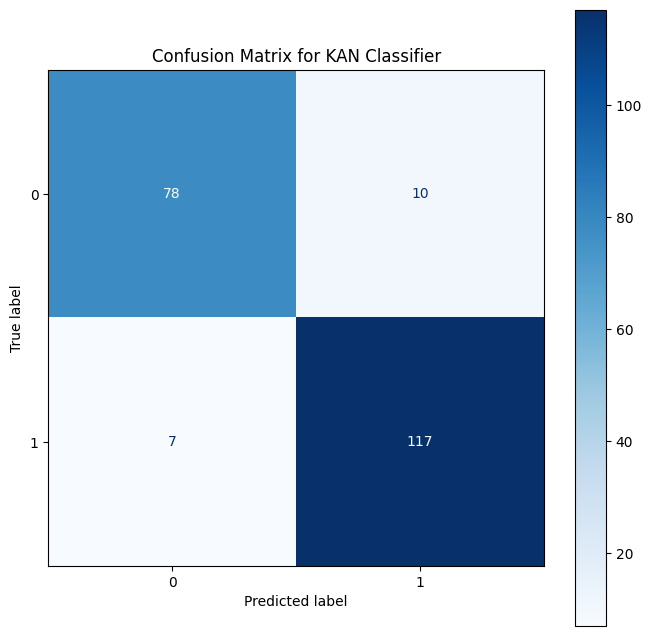

In [ ]:
# Custom KAN layer
class KANLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_rate=0.2):
        super(KANLayer, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(self.fc(x))

# Custom KAN model
class KAN(nn.Module):
    def __init__(self, width):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(width) - 1):
            self.layers.append(KANLayer(width[i], width[i+1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                x = torch.relu(layer(x))
            else:
                x = torch.sigmoid(layer(x))
        return x

# Load the dataset
file_path = 'Final_dataset_Classific.xlsx'
dataset = pd.read_excel(file_path)
cols_to_drop = dataset.filter(like='Medication_').columns
dataset = dataset.drop(columns=cols_to_drop)

# Prepare data for the classification task
dataset['Outcome_numerical_step1'] = dataset['Outcome_numerical'].replace(2, 0)
X = dataset.drop(columns=['Outcome_numerical', 'Outcome_numerical_step1'])
y = dataset['Outcome_numerical_step1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
accuracies = []

def train_kan(model, criterion, optimizer, scheduler, X_train, y_train, epochs=50):
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step()

for train_idx, val_idx in kfold.split(X_scaled, y):
    print(f'Training for fold {fold_no}...')

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_scaled[train_idx], dtype=torch.float32)
    y_train_tensor = torch.tensor(y[train_idx].values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_scaled[val_idx], dtype=torch.float32)
    y_val_tensor = torch.tensor(y[val_idx].values, dtype=torch.float32).view(-1, 1)

    # Initialize the KAN model
    width = [X_train_tensor.shape[1], 128, 64, 32, 1]
    kan_model = KAN(width=width)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(kan_model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    # Train the KAN model
    train_kan(kan_model, criterion, optimizer, scheduler, X_train_tensor, y_train_tensor)

    # Make predictions on the validation set
    kan_model.eval()
    with torch.no_grad():
        y_pred_val_tensor = kan_model(X_val_tensor)
    y_pred_val = (y_pred_val_tensor.numpy() > 0.5).astype(int)

    # Calculate validation accuracy
    val_accuracy = accuracy_score(y[val_idx], y_pred_val)
    accuracies.append(val_accuracy)

    print(f'Fold {fold_no} Accuracy: {val_accuracy * 100:.2f}%')
    fold_no += 1

print(f'Average Validation Accuracy: {np.mean(accuracies) * 100:.2f}%')

# Final model evaluation on the whole test set
train_data, test_data = train_test_split(dataset, test_size=0.45, random_state=42)
X_test = test_data.drop(columns=['Outcome_numerical', 'Outcome_numerical_step1'])
X_test_scaled = scaler.transform(X_test)
y_test = test_data['Outcome_numerical'].replace(2, 0)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Make predictions on the test set
kan_model.eval()
with torch.no_grad():
    y_pred_test_tensor = kan_model(X_test_tensor)
y_pred_test = (y_pred_test_tensor.numpy() > 0.5).astype(int)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Add predictions to test_data
test_data['Predicted_step1'] = y_pred_test

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for KAN Classifier')
plt.show()


Training for fold 1...
Fold 1 Accuracy: 82.98%
Training for fold 2...
Fold 2 Accuracy: 87.23%
Training for fold 3...
Fold 3 Accuracy: 93.62%
Training for fold 4...
Fold 4 Accuracy: 80.85%
Training for fold 5...
Fold 5 Accuracy: 85.11%
Training for fold 6...
Fold 6 Accuracy: 74.47%
Training for fold 7...
Fold 7 Accuracy: 87.23%
Training for fold 8...
Fold 8 Accuracy: 91.49%
Training for fold 9...
Fold 9 Accuracy: 76.60%
Training for fold 10...
Fold 10 Accuracy: 87.23%
Average Validation Accuracy: 84.68%


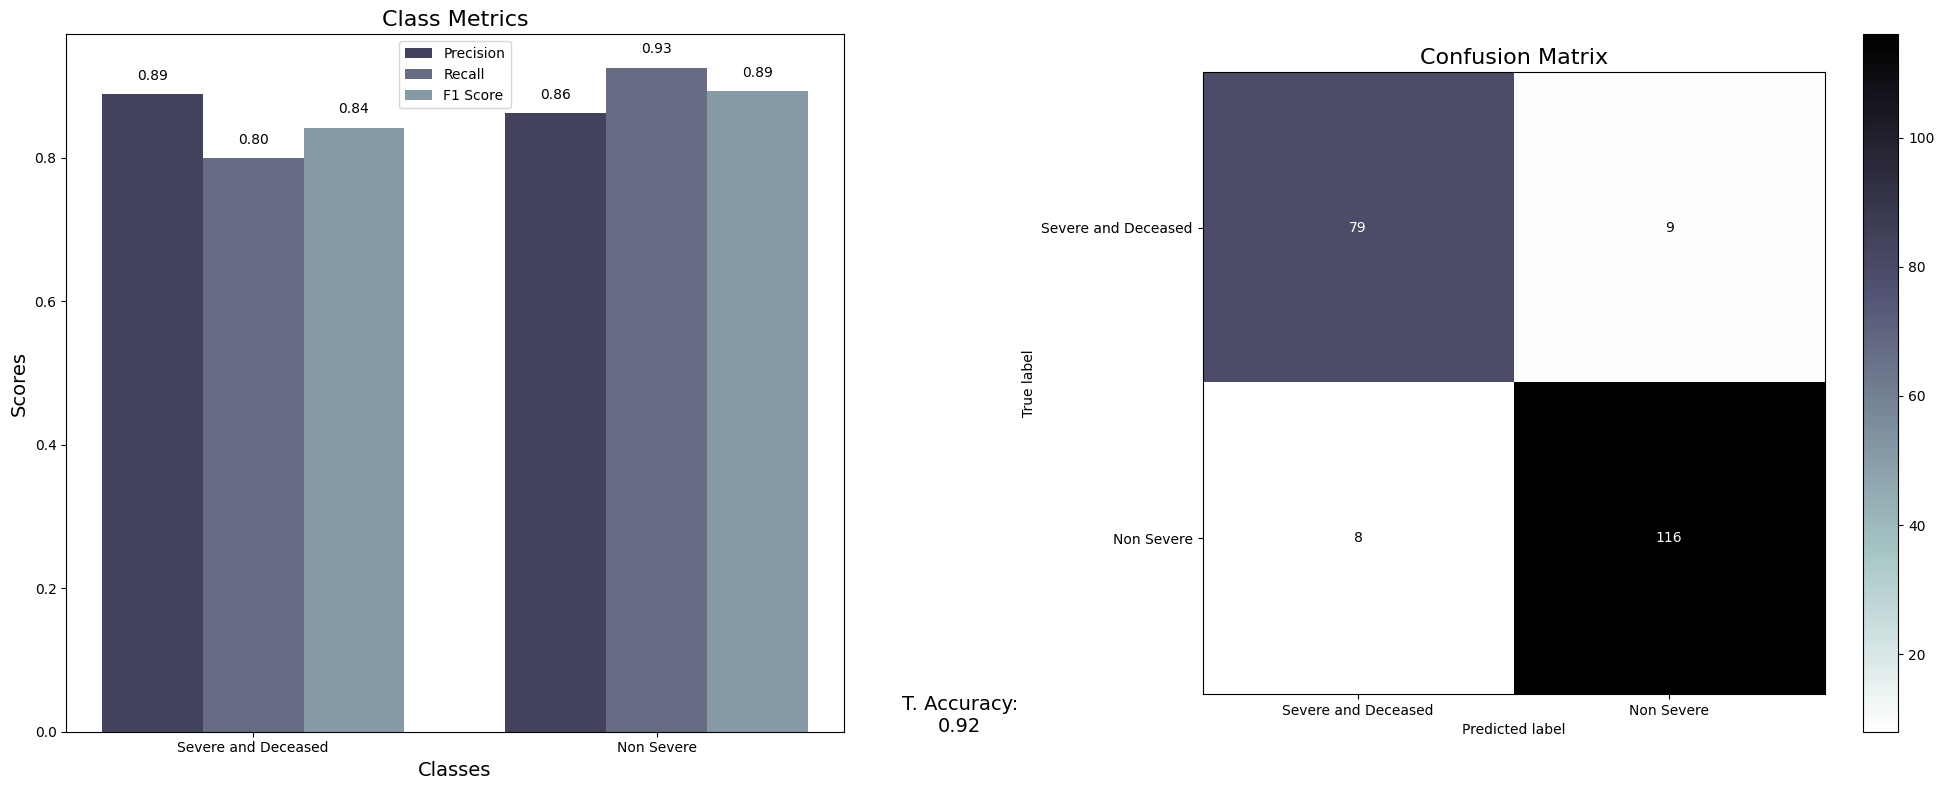

In [ ]:
# Custom KAN layer
class KANLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_rate=0.2):
        super(KANLayer, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(self.fc(x))

# Custom KAN model
class KAN(nn.Module):
    def __init__(self, width, dropout_rate=0.2):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(width) - 1):
            self.layers.append(KANLayer(width[i], width[i+1], dropout_rate=dropout_rate))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                x = torch.relu(layer(x))
            else:
                x = torch.sigmoid(layer(x))
        return x

# Load the dataset
file_path = 'Final_dataset_Classific.xlsx'
dataset = pd.read_excel(file_path)
cols_to_drop = dataset.filter(like='Medication_').columns
dataset = dataset.drop(columns=cols_to_drop)

# Prepare data for the classification task
dataset['Outcome_numerical_step1'] = dataset['Outcome_numerical'].replace(2, 0)
X = dataset.drop(columns=['Outcome_numerical', 'Outcome_numerical_step1'])
y = dataset['Outcome_numerical_step1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
accuracies = []

def train_kan(model, criterion, optimizer, scheduler, X_train, y_train, epochs=50):
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step()

for train_idx, val_idx in kfold.split(X_scaled, y):
    print(f'Training for fold {fold_no}...')

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_scaled[train_idx], dtype=torch.float32)
    y_train_tensor = torch.tensor(y.iloc[train_idx].values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_scaled[val_idx], dtype=torch.float32)
    y_val_tensor = torch.tensor(y.iloc[val_idx].values, dtype=torch.float32).view(-1, 1)

    # Initialize the KAN model
    width = [X_train_tensor.shape[1], 128, 64, 32, 1]  # Adjust the structure based on data
    kan_model = KAN(width=width)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(kan_model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    # Train the KAN model
    train_kan(kan_model, criterion, optimizer, scheduler, X_train_tensor, y_train_tensor)

    # Make predictions on the validation set
    kan_model.eval()
    with torch.no_grad():
        y_pred_val_tensor = kan_model(X_val_tensor)
    y_pred_val = (y_pred_val_tensor.numpy() > 0.5).astype(int)

    # Calculate validation accuracy
    val_accuracy = accuracy_score(y.iloc[val_idx], y_pred_val)
    accuracies.append(val_accuracy)

    print(f'Fold {fold_no} Accuracy: {val_accuracy * 100:.2f}%')
    fold_no += 1

print(f'Average Validation Accuracy: {np.mean(accuracies) * 100:.2f}%')

# Calculate class-wise metrics
overall_precision = precision_score(y.iloc[val_idx], y_pred_val, average=None)
overall_recall = recall_score(y.iloc[val_idx], y_pred_val, average=None)
overall_f1 = f1_score(y.iloc[val_idx], y_pred_val, average=None)

# Final model evaluation on the whole test set
train_data, test_data = train_test_split(dataset, test_size=0.45, random_state=42)
X_test = test_data.drop(columns=['Outcome_numerical', 'Outcome_numerical_step1'])
X_test_scaled = scaler.transform(X_test)
y_test = test_data['Outcome_numerical'].replace(2, 0)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Make predictions on the test set
kan_model.eval()
with torch.no_grad():
    y_pred_test_tensor = kan_model(X_test_tensor)
y_pred_test = (y_pred_test_tensor.numpy() > 0.5).astype(int)

# Calculate test accuracy and bootstrap CI
test_accuracy = accuracy_score(y_test, y_pred_test)

# Add predictions to test_data
test_data['Predicted_step1'] = y_pred_test

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Visualize the class-wise metrics and confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))
# Class Metrics Display
class_labels = ['Severe and Deceased', 'Non Severe']
bar_width = 0.25
index = np.arange(len(class_labels))

axes[0].bar(index, overall_precision, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, overall_recall, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, overall_f1, bar_width, color=bone_palette[2], label='F1 Score')

axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Adding text annotations for precision, recall, and F1
for i in range(len(class_labels)):
    axes[0].text(i, overall_precision[i] + 0.02, f'{overall_precision[i]:.2f}', ha='center')
    axes[0].text(i + bar_width, overall_recall[i] + 0.02, f'{overall_recall[i]:.2f}', ha='center')
    axes[0].text(i + 2 * bar_width, overall_f1[i] + 0.02, f'{overall_f1[i]:.2f}', ha='center')

# Adding overall accuracy
axes[0].text(len(class_labels), 0, f'T. Accuracy:\n{test_accuracy:.2f}', fontsize=14, ha='center')

# Confusion Matrix Display
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Confusion Matrix', fontsize=16)

plt.tight_layout()
plt.show()


In [27]:
from scipy import stats

# Convert test data to NumPy arrays
X_test_np = X_test_scaled
y_test_np = y_test.to_numpy()

# Update the bootstrapping function to handle NumPy arrays directly
def calculate_bootstrap_accuracy_np(X_test, y_test, kan_model, n_samples=1000, random_state=42):
    rng = np.random.RandomState(random_state)
    accuracies = []

    for _ in range(n_samples):
        sample_indices = rng.choice(len(X_test), len(X_test), replace=True)
        X_sample = X_test[sample_indices]
        y_sample = y_test[sample_indices]

        # Convert to tensors
        X_sample_tensor = torch.tensor(X_sample, dtype=torch.float32)
        y_sample_tensor = torch.tensor(y_sample, dtype=torch.float32).view(-1, 1)

        # Make predictions
        kan_model.eval()
        with torch.no_grad():
            y_pred_sample_tensor = kan_model(X_sample_tensor)
        y_pred_sample = (y_pred_sample_tensor.numpy() > 0.5).astype(int)

        # Calculate accuracy
        accuracy = accuracy_score(y_sample, y_pred_sample)
        accuracies.append(accuracy)

    return np.array(accuracies)

# Compute the bootstrap accuracies using the NumPy arrays
bootstrap_accuracies = calculate_bootstrap_accuracy_np(X_test_np, y_test_np, kan_model)

# Compute the 95% confidence interval
lower_ci, upper_ci = np.percentile(bootstrap_accuracies, [2.5, 97.5])
mean_accuracy = np.mean(bootstrap_accuracies)

print(f'Bootstrap Mean Accuracy: {mean_accuracy * 100:.2f}%')
print(f'95% Confidence Interval: [{lower_ci * 100:.2f}%, {upper_ci * 100:.2f}%]')


Bootstrap Mean Accuracy: 90.58%
95% Confidence Interval: [86.32%, 94.34%]


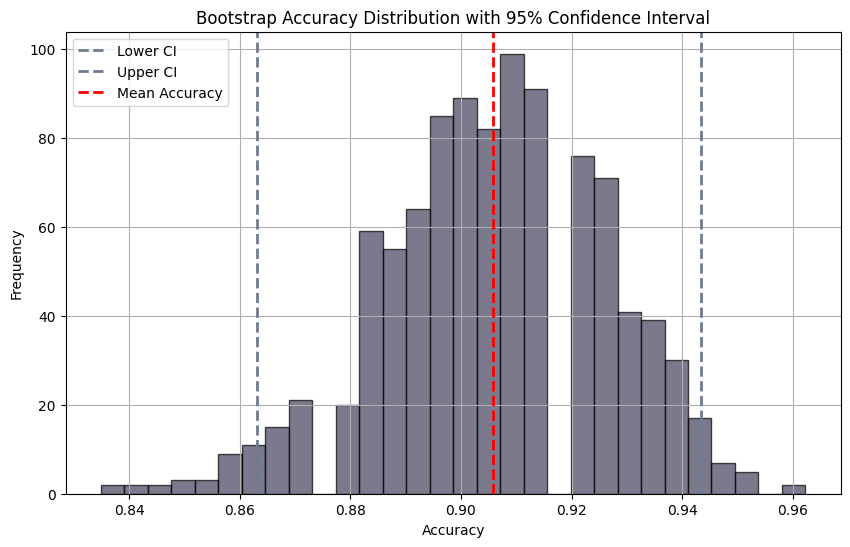

In [30]:
# Get bone colors from the colormap
bone_palette = plt.cm.bone(np.linspace(0.3, 0.7, 3))
hist_color = bone_palette[0]
lower_ci_color = bone_palette[1]
upper_ci_color = bone_palette[1]
mean_color = bone_palette[2]

# Plot the distribution of accuracies
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_accuracies, bins=30, color=hist_color, edgecolor='k', alpha=0.7)
plt.axvline(lower_ci, color=lower_ci_color, linestyle='dashed', linewidth=2, label='Lower CI')
plt.axvline(upper_ci, color=upper_ci_color, linestyle='dashed', linewidth=2, label='Upper CI')
plt.axvline(mean_accuracy, color='red', linestyle='dashed', linewidth=2, label='Mean Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Bootstrap Accuracy Distribution with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

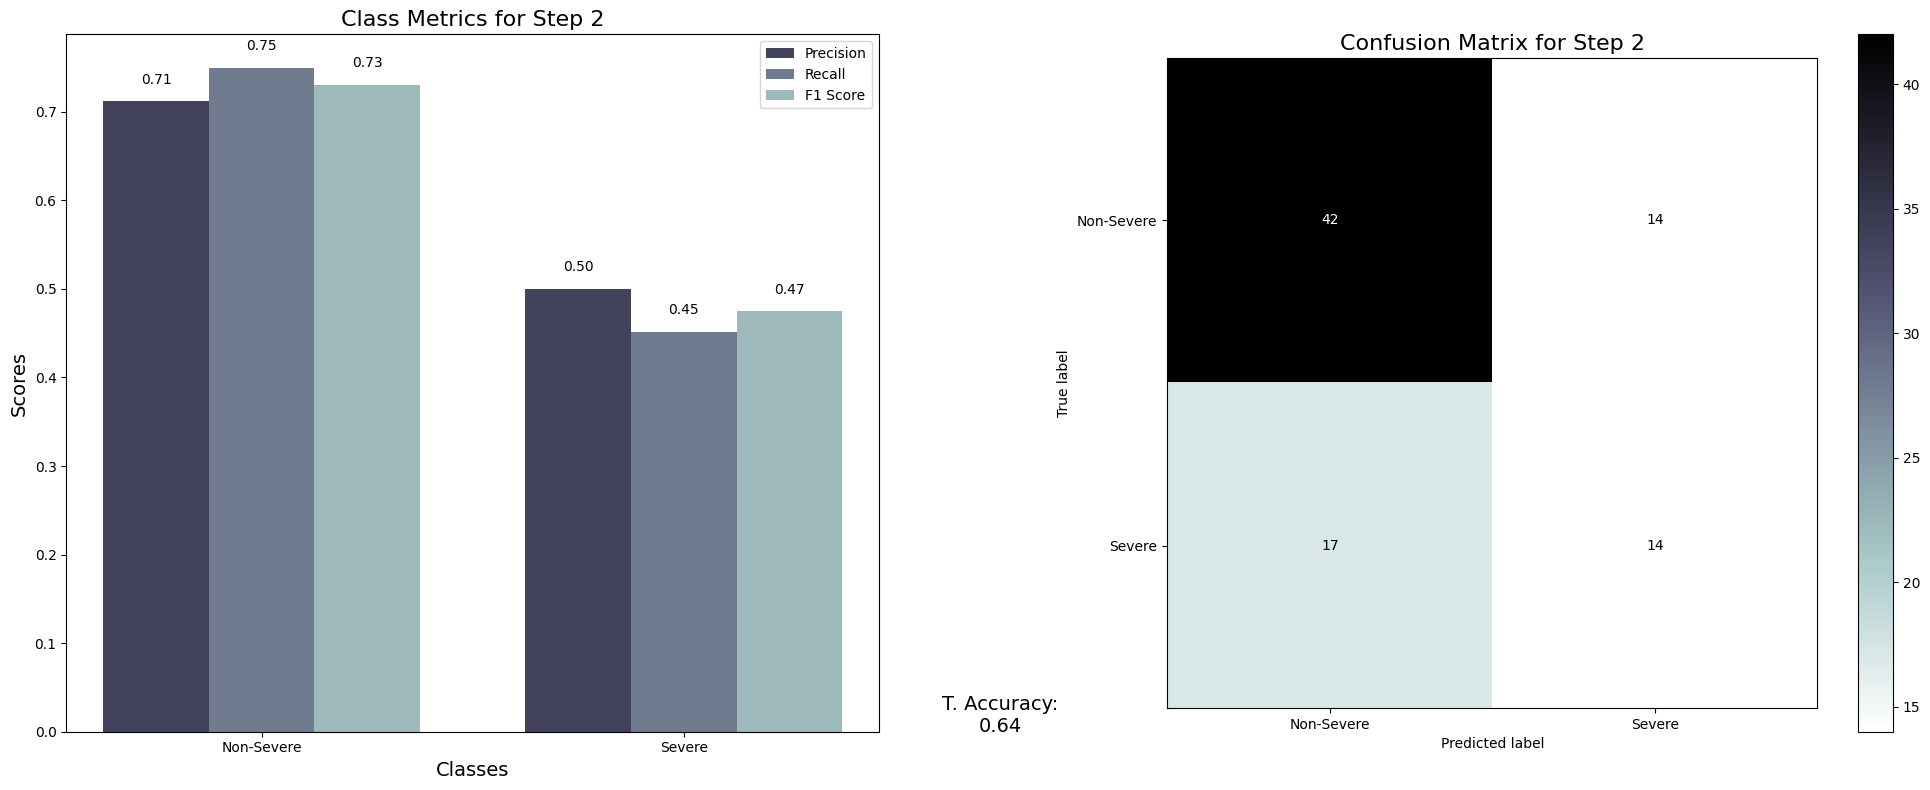

Bootstrap Mean Accuracy: 0.6436781609195402
95% Confidence Interval: [0.5402298850574713, 0.7471264367816092]


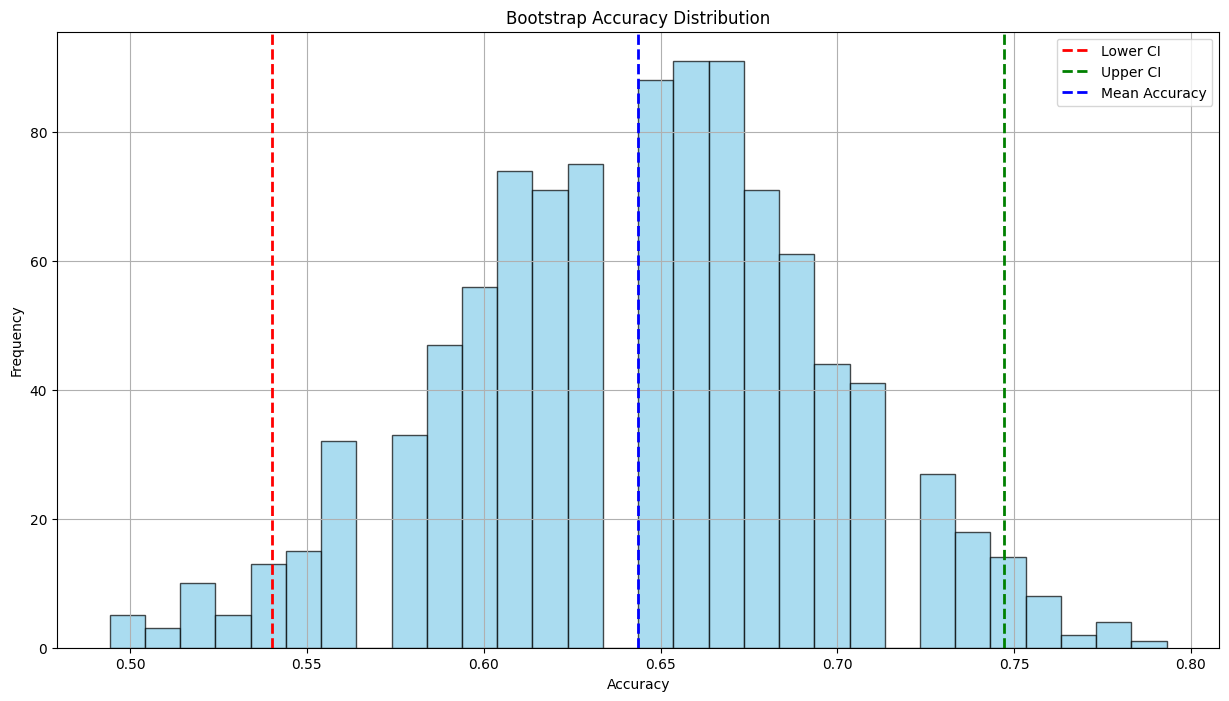

In [ ]:
# Custom KAN layer
class KANLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_rate=0.2):
        super(KANLayer, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(self.fc(x))

# Custom KAN model
class KAN(nn.Module):
    def __init__(self, width):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(width) - 1):
            self.layers.append(KANLayer(width[i], width[i+1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                x = torch.relu(layer(x))
            else:
                x = torch.sigmoid(layer(x))
        return x

# Train function for the KAN model
def train_kan(model, criterion, optimizer, scheduler, X_train, y_train, epochs=50):
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step()

# Update the function to use NumPy arrays
def bootstrap_accuracy_np(model, X_test, y_test, n_samples=1000, random_state=42):
    rng = np.random.RandomState(random_state)
    accuracies = []

    for _ in range(n_samples):
        sample_indices = rng.choice(len(X_test), len(X_test), replace=True)
        X_sample = X_test[sample_indices]
        y_sample = y_test[sample_indices]

        # Convert to tensors
        X_sample_tensor = torch.tensor(X_sample, dtype=torch.float32)
        y_sample_tensor = torch.tensor(y_sample, dtype=torch.float32).view(-1, 1)

        # Make predictions
        model.eval()
        with torch.no_grad():
            y_pred_sample_tensor = model(X_sample_tensor)
        y_pred_sample = (y_pred_sample_tensor.numpy() > 0.5).astype(int)

        # Calculate accuracy
        accuracy = accuracy_score(y_sample, y_pred_sample)
        accuracies.append(accuracy)

    return np.array(accuracies)

test_data['Predicted_step1'] = y_pred_test

# Prepare the test set for Step 2
test_data_step2 = test_data[test_data['Predicted_step1'] == 0]
X_test_step2 = test_data_step2.drop(columns=['Outcome_numerical', 'Predicted_step1'])
y_test_step2 = test_data_step2['Outcome_numerical'].replace(2, 1)

# Prepare the training data for Step 2 (binary classification: class 0 vs class 2-as-1)
train_data_step2 = train_data[train_data['Outcome_numerical'] != 1]
X_train_step2 = train_data_step2.drop(columns=['Outcome_numerical', 'Outcome_numerical_step1'])
y_train_step2 = train_data_step2['Outcome_numerical'].replace(2, 1)

# Standardize features for Step 2
scaler_step2 = StandardScaler()
X_train_step2_scaled = scaler_step2.fit_transform(X_train_step2)

# Apply SMOTE for Step 2 to handle class imbalance
smote = SMOTE(random_state=42)
X_train_step2_smote, y_train_step2_smote = smote.fit_resample(X_train_step2_scaled, y_train_step2)

# Convert training data to PyTorch tensors
X_train_step2_tensor = torch.tensor(X_train_step2_smote, dtype=torch.float32)
y_train_step2_tensor = torch.tensor(y_train_step2_smote.values, dtype=torch.float32).view(-1, 1)

# Initialize the KAN model for Step 2
width_step2 = [X_train_step2_tensor.shape[1], 64, 32, 1]
kan_model_step2 = KAN(width=width_step2)
criterion_step2 = nn.BCELoss()
optimizer_step2 = optim.Adam(kan_model_step2.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_step2 = optim.lr_scheduler.StepLR(optimizer_step2, step_size=20, gamma=0.5)

# Train the KAN model for Step 2
train_kan(kan_model_step2, criterion_step2, optimizer_step2, scheduler_step2, X_train_step2_tensor, y_train_step2_tensor, epochs=50)

# Ensure 'Outcome_numerical_step1' is not part of the test features
X_test_step2_scaled = scaler_step2.transform(X_test_step2[X_train_step2.columns])

# Convert test data to PyTorch tensors
X_test_step2_tensor = torch.tensor(X_test_step2_scaled, dtype=torch.float32)
y_test_step2_tensor = torch.tensor(y_test_step2.values, dtype=torch.float32).view(-1, 1)

# Make predictions for Step 2 using KAN
kan_model_step2.eval()
with torch.no_grad():
    y_pred_step2_tensor = kan_model_step2(X_test_step2_tensor)
y_pred_step2 = (y_pred_step2_tensor.numpy() > 0.5).astype(int)

# Calculate evaluation metrics for Step 2
precision_step2 = precision_score(y_test_step2, y_pred_step2, average=None)
recall_step2 = recall_score(y_test_step2, y_pred_step2, average=None)
f1_step2 = f1_score(y_test_step2, y_pred_step2, average=None)
accuracy_step2 = accuracy_score(y_test_step2, y_pred_step2)

# Create a 1x2 grid for bar chart and confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
bone_palette = plt.cm.bone(np.linspace(0.3, 0.7, 3))

# Plot class-wise metrics on the first subplot
class_labels = ['Non-Severe', 'Severe']
metrics = [precision_step2, recall_step2, f1_step2]
metric_names = ['Precision', 'Recall', 'F1 Score']
bar_width = 0.25
index = np.arange(len(class_labels))

# Plotting the metrics
for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    axes[0].bar(index + i * bar_width, metric, bar_width, color=bone_palette[i], label=name)

axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('Class Metrics for Step 2', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Adding text annotations for precision, recall, and F1
for i in range(len(class_labels)):
    for j, metric_name in enumerate(metric_names):
        metric_value = metrics[j][i]
        axes[0].text(i + j * bar_width, metric_value + 0.02, f'{metric_value:.2f}', ha='center')

# Adding overall accuracy
axes[0].text(len(class_labels), 0, f'T. Accuracy:\n{accuracy_step2:.2f}', fontsize=14, ha='center')

# Plot the confusion matrix on the second subplot
conf_matrix_labels = ['Non-Severe', 'Severe']
conf_matrix = confusion_matrix(y_test_step2, y_pred_step2)
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=conf_matrix_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Confusion Matrix for Step 2', fontsize=16)

plt.tight_layout()
plt.show()

# Calculate bootstrap accuracies
X_test_step2_np = X_test_step2_scaled
y_test_step2_np = y_test_step2.to_numpy()
bootstrap_accuracies = bootstrap_accuracy_np(kan_model_step2, X_test_step2_np, y_test_step2_np)
mean_accuracy = np.mean(bootstrap_accuracies)
lower_ci, upper_ci = np.percentile(bootstrap_accuracies, [2.5, 97.5])

print(f"Bootstrap Mean Accuracy: {mean_accuracy}")
print(f"95% Confidence Interval: [{lower_ci}, {upper_ci}]")

# Plot the bootstrap accuracy distribution separately
plt.figure(figsize=(15, 8))
plt.hist(bootstrap_accuracies, bins=30, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(lower_ci, color='red', linestyle='dashed', linewidth=2, label='Lower CI')
plt.axvline(upper_ci, color='green', linestyle='dashed', linewidth=2, label='Upper CI')
plt.axvline(mean_accuracy, color='blue', linestyle='dashed', linewidth=2, label='Mean Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Bootstrap Accuracy Distribution')
plt.legend()
plt.grid(True)
plt.show()


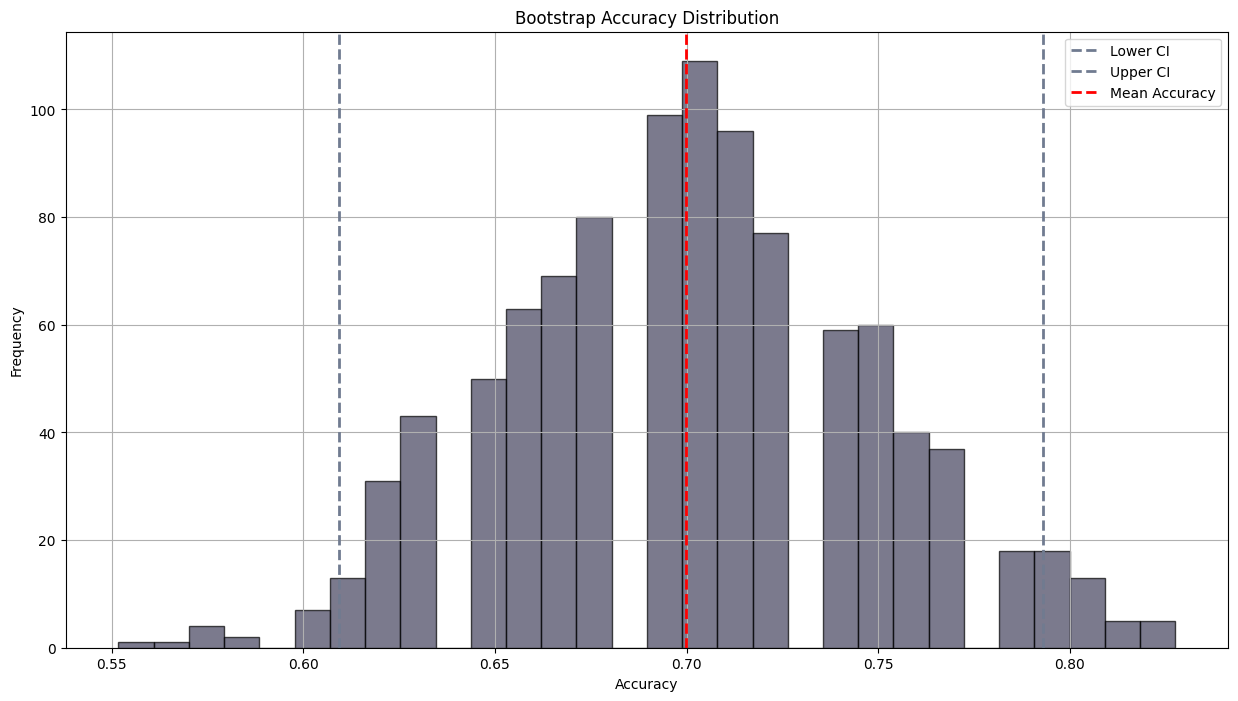

In [153]:
# Get bone colors from the colormap
bone_palette = plt.cm.bone(np.linspace(0.3, 0.7, 3))
hist_color = bone_palette[0]
lower_ci_color = bone_palette[1]
upper_ci_color = bone_palette[1]
mean_color = bone_palette[2]
# Plot the bootstrap accuracy distribution separately
plt.figure(figsize=(15, 8))
plt.hist(bootstrap_accuracies, bins=30, color=hist_color, edgecolor='k', alpha=0.7)
plt.axvline(lower_ci, color=lower_ci_color, linestyle='dashed', linewidth=2, label='Lower CI')
plt.axvline(upper_ci, color=upper_ci_color, linestyle='dashed', linewidth=2, label='Upper CI')
plt.axvline(mean_accuracy, color='red', linestyle='dashed', linewidth=2, label='Mean Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Bootstrap Accuracy Distribution')
plt.legend()
plt.grid(True)
plt.show()

Final Model Accuracy: 0.8160377358490566
Final Model Precision: 0.7245347985347985
Final Model Recall: 0.7420925072537976
Final Model F1 Score: 0.7260345730749083


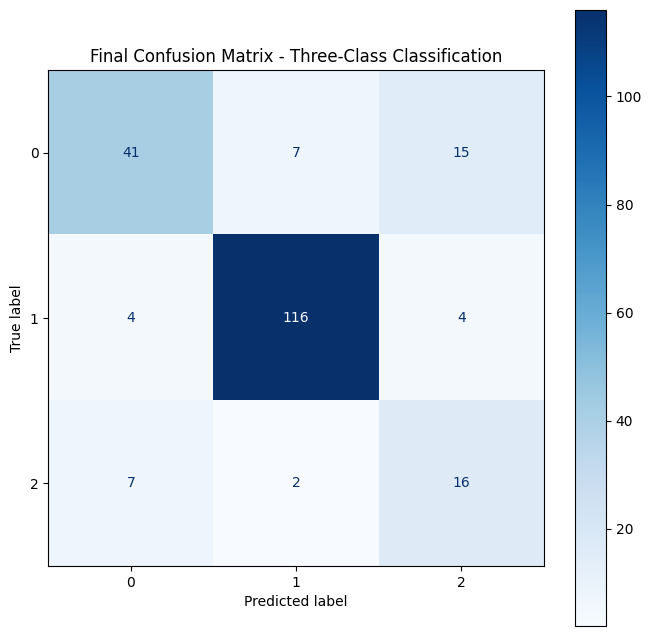

In [ ]:
# Step 2 re-encoding needs to be reversed for the final classification
test_data.loc[test_data_step2.index, 'Predicted_step2'] = y_pred_step2
test_data.loc[test_data_step2.index, 'Predicted_step2'] = test_data['Predicted_step2'].replace(1, 2)

# Combine Step 1 and Step 2 predictions into a final classification result
def combine_predictions(row):
    if row['Predicted_step1'] == 1:
        return 1  # Direct classification as class 1
    else:
        return row['Predicted_step2']  # Either 0 or 2 as classified in Step 2

test_data['Final_Prediction'] = test_data.apply(combine_predictions, axis=1)

# Evaluation with the original classes
y_true = test_data['Outcome_numerical']  # Assuming this column has the original class labels
y_pred_final = test_data['Final_Prediction']

# Calculate and display evaluation metrics for the final three-class classification
accuracy_final = accuracy_score(y_true, y_pred_final)
precision_final = precision_score(y_true, y_pred_final, average='macro')
recall_final = recall_score(y_true, y_pred_final, average='macro')
f1_final = f1_score(y_true, y_pred_final, average='macro')

print(f"Final Model Accuracy: {accuracy_final}")
print(f"Final Model Precision: {precision_final}")
print(f"Final Model Recall: {recall_final}")
print(f"Final Model F1 Score: {f1_final}")

# Visualize the final confusion matrix
conf_matrix_final = confusion_matrix(y_true, y_pred_final)
fig, ax = plt.subplots(figsize=(8, 8))
disp_final = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_final, display_labels=[0, 1, 2])
disp_final.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Final Confusion Matrix - Three-Class Classification')
plt.show()


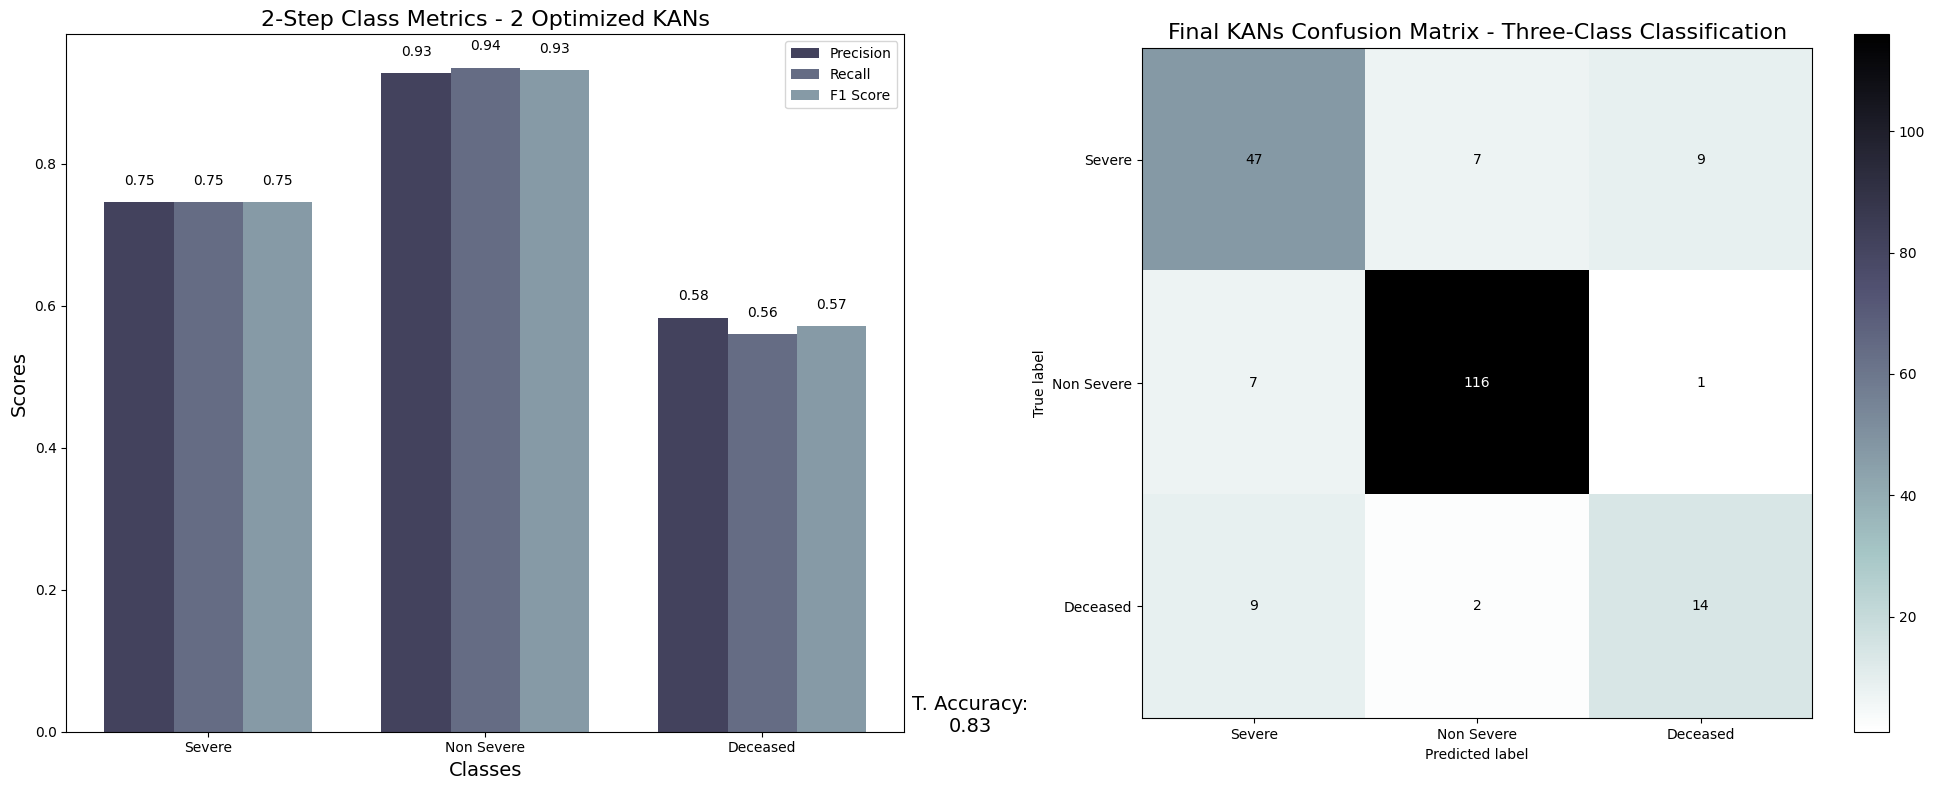

In [ ]:
# Calculate and display evaluation metrics for the final three-class classification
accuracy_final = accuracy_score(y_true, y_pred_final)
precision_final = precision_score(y_true, y_pred_final, average=None)  # Changed to None for individual class scores
recall_final = recall_score(y_true, y_pred_final, average=None)  
f1_final = f1_score(y_true, y_pred_final, average=None)  
conf_matrix_final = confusion_matrix(y_true, y_pred_final)

class_labels = ['Severe', 'Non Severe', 'Deceased']

# Creating a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))  # Color palette

bar_width = 0.25
index = np.arange(len(class_labels))

# Plotting precision, recall, and F1-score for each class
axes[0].bar(index, precision_final, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, recall_final, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, f1_final, bar_width, color=bone_palette[2], label='F1 Score')

# Setting labels and titles
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('2-Step Class Metrics - 2 Optimized KANs', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Adding text annotations for clarity
for i in range(len(class_labels)):
    axes[0].text(i, precision_final[i] + 0.02, f'{precision_final[i]:.2f}', ha='center', va='bottom')
    axes[0].text(i + bar_width, recall_final[i] + 0.02, f'{recall_final[i]:.2f}', ha='center', va='bottom')
    axes[0].text(i + 2 * bar_width, f1_final[i] + 0.02, f'{f1_final[i]:.2f}', ha='center', va='bottom')

axes[0].text(len(class_labels), 0, f'T. Accuracy:\n{accuracy_final:.2f}', fontsize=14, ha='center')
# Confusion Matrix Display
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_final, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Final KANs Confusion Matrix - Three-Class Classification', fontsize=16)

plt.tight_layout()
plt.show()
